# 基于地铁IC刷卡数据的上海市轨道交通客流分析

## 研究背景

随着全球城市化进程的不断加速，城市轨道交通系统作为一种高效便捷的交通方式，在现代城市中发挥着日益重要的作用。上海市作为中国最大的城市之一，其轨道交通网络已经发展成为全球最长、规模最大的城市轨道交通系统之一。随着上海市轨道交通网络的不断扩张和客流量的增加，对于客流分析和预测的需求也日益迫切。

在过去，轨道交通客流分析主要依赖于人工抽样调查和票务系统统计数据，这种方法往往存在抽样误差和时间成本较高的问题。然而，近年来随着智能化技术的发展和城市IC卡系统的普及应用，越来越多的城市开始采集地铁IC刷卡数据，并且通过大数据分析方法来进行客流分析和预测，这为城市轨道交通运营和规划提供了全新的视角和方法。

上海市作为一个典型的大都市，其地铁IC刷卡数据蕴含着丰富的信息，包括乘客进出站的时间、地点、乘车线路等。通过对这些数据的深入研究和分析，可以揭示出城市轨道交通系统的客流特征、出行规律以及拥挤状况等重要信息，为城市轨道交通运营管理、线路规划优化和交通政策制定提供科学依据。

本项目旨在基于上海市轨道交通的IC刷卡数据进行客流分析，通过挖掘和分析数据中隐藏的规律和模式，探索上海市轨道交通系统的客流动态、高峰时段、热门线路等特征，为城市轨道交通的运营管理和决策提供有力支持。

通过这项研究，我们有望为上海市轨道交通的可持续发展和城市交通规划提供重要参考，同时为其他城市的轨道交通客流分析和预测提供经验和借鉴。这对于改善城市居民的出行体验、减少交通拥堵、提高交通运营效率具有重要意义，也是建设智慧城市和可持续城市的重要一步。


## 数据简介

基础数据包括2020年的上海市地铁线数据“line.json”和上海市地铁站点数据“stop.csv”、2015年4月1日上海市全体地铁IC刷卡数据“icdata-sample.csv”，都放在data文件夹中，文件夹中还存储着相关但没有使用的数据。此外，保存的数据也存储在data文件夹中。

## 操作思路简介

首先，对输入的地铁GIS数据和IC刷卡数据两部分分别进行预处理：

- 一方面，对地铁GIS数据，将其空间拓扑结构抽象成为点与边构成的网络，在Python中的网络分析包NetworkX中进行网络建模。
- 另一方面，对IC刷卡数据，提取出其中的地铁出行部分，并整理出其中的OD出行信息。

接下来，将构建好的地铁网络与OD出行信息结合，对每个出行OD判断其出行路径，并集计断面客流。最后，基于客流信息计算地铁客流指标，分析客流特征，并进行可视化。注意本项目最终的结果是2号线早8点的断面客流分布柱状图以及早8点上海市轨道交通线路断面客流蛛网图，并不涵盖全部的线路或者全部的时间段。

![image](images/操作思路流程图.png)

## 我的代码阅读指南

这里是一些阅读前的提示：

- 下面您将开始阅读我的代码，建议不使用原生的jupyter在浏览器阅读，那个太看起来丑了，请使用vscode或pycharm中的jupyter模块打开。
- 本项目的标题采用三级标题制：
  - 1个数字表示大的模块，本项目分为5个模块，分别是导入所有需要的包、地铁网络构建、地铁出行路径提取、轨道断面客流分布可视化、轨道断面客流蛛网图可视化；
  - 2个数字的“数字.数字”形式表示完成每个模块的步骤；
  - 3个数字的“数字.数字.数字”代表一个功能的实现，是项目结构中分级的最小级别。每一个小功能的实现可能需要一段代码块或者多段代码块（即三级标题下的代码块数量不定）。
- 下面的内容除了标题，就是正文解释和代码块。正文解释一般放在标题后或者代码块前，具体要看它是对这一个标题要做的内容的解释，还是对某一段代码块的思路和目的进行解释，而代码中的每一行基本都有注释以便于理解。
- 正文解释部分可能会有图片用以结合说明思路。图片使用[tldraw](https://www.tldraw.com/)绘制。

## 0 导入所有需要的包

In [148]:
# 导入所有需要使用的包
import geopandas as gpd
import pandas as pd
import networkx as nx
import warnings
import matplotlib
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import numpy as np

# 忽略一些错误
warnings.filterwarnings("ignore")

## 1 地铁网络构建

在IC刷卡数据中，我们可以提取出进出站信息，但由于刷卡数据中不包括出行路径信息，如果想知道轨道中每一个断面的客流量信息，我们就需要通过构建地铁网络来进行研究。

一个网络由节点和边两个必不可少的结构组成，构建地铁网络时，我们需要将实际的地铁信息转化为节点与边构成的抽象网络。我们很容易想到，节点即为地铁站点，而边为地铁站点之间的连接，在构建出网络以后，我们只要指定一个进站的节点和一个出站的节点，就可以根据连通情况搜寻可能的路径，进而推测出出行路径。

但我们需要考虑以下几个问题：
1. 边的权重如何设置？边的权重是各个路径算法中必不可少的，一般以距离、时间作为指标。
2. 换乘如何考虑？实际生活中，我们很少一条地铁坐到底，换乘是更为常见的选择，我们怎么在网络中体现呢？
3. 使用哪种路径选择模型？

我选择在构建网络时将网络中的边分为“轨道边”和“换乘边”两种，然后以出行时间作为目标，具体如下：
- 轨道边：对于同一线路上的相同站点，在网络中两个相邻站点间要有一条边，并以出行时间作为边的权重，出行时间应该包括列车运行时间与停站时间，我根据个人经验统一赋值为3分钟，这样方便了计算，事实上针对不同的城市，我们可以修改权重或者根据实际情况对每一条轨道边进行赋值，这样结果会更精确。
- 换乘边：换乘怎么解决呢？我们在网络中添加边时，如果某一个站点属于多条线路，我们需要将其区分开来，举个例子，在中北校区乘坐地铁时，3号线和4号线有很大一段的交叉，比如“中山公园”站就同属于两条线路，那么就得有两个节点，都叫做“中山公园”站，但一条属于3号线，一条属于4号线，即它们只是代表的站点名字一样，但实际上是两个完全不一样的节点。然后我们在这两个“中山公园”站节点之间添加一条换乘边以代表一个站点内从一个线路换乘到另外一个线路的过程，其权重为一个站点内不同站台之间的步行时间，同样的，为了方便计算，我根据个人经验统一赋值为5分钟。
- 最短路径：为了方便计算，以及考虑到上海的出行情况，我们使用最短路径模型来进行研究。

![image](images/换乘边示意图.png)

因此本节中我们首先利用线路和站点数据将地铁网络构建出来，然后使用NetworkX进行网络建模，以便于路径提取。

### 1.1 地铁线网数据读取

#### 1.1.1 读取2020年上海市地铁线路数据

线路数据文件格式为GeoJSON，共有17条线路与344个站点。

,city,linename,geometry
0,上海,地铁1号线(莘庄-富锦路),"LINESTRING (121.38038 31.11283, 121.38183 31.1..."
1,上海,地铁1号线(富锦路-莘庄),"LINESTRING (121.41995 31.39422, 121.42026 31.3..."
2,上海,地铁3号线(江杨北路-上海南站),"LINESTRING (121.43520 31.40966, 121.43927 31.4..."
3,上海,地铁3号线(上海南站-江杨北路),"LINESTRING (121.42611 31.15522, 121.42855 31.1..."
4,上海,地铁4号线(内圈(宜山路-宜山路)),"LINESTRING (121.42282 31.18865, 121.42146 31.1..."
5,上海,地铁4号线(外圈(宜山路-宜山路)),"LINESTRING (121.42282 31.18865, 121.42337 31.1..."
6,上海,地铁10号线(航中路-新江湾城),"LINESTRING (121.35015 31.16762, 121.35620 31.1..."
7,上海,地铁10号线(新江湾城-航中路),"LINESTRING (121.50218 31.33079, 121.50217 31.3..."
8,上海,地铁10号线(虹桥火车站-新江湾城),"LINESTRING (121.31699 31.19587, 121.31827 31.1..."
9,上海,地铁10号线(新江湾城-虹桥火车站),"LINESTRING (121.50218 31.33079, 121.50217 31.3..."


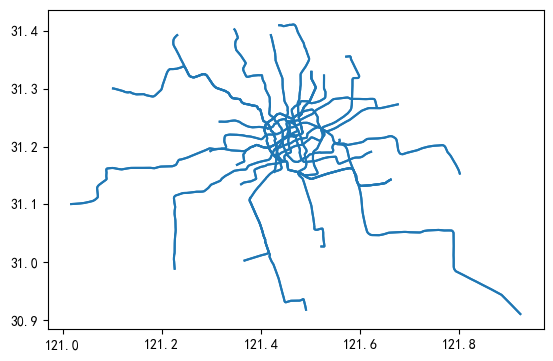

In [149]:
# 读取线路数据
line = gpd.GeoDataFrame.from_file('data/line.json', encoding="utf-8")
# 绘制线路图
line.plot()
# 查看线路信息
line

#### 1.1.2 读取带有经纬度列的地铁轨道站点数据

因为一个站点可能属于多条线路，在数据中则会出现多次，因此地铁站点数据的数据量会比实际的地铁站多。

In [150]:
# 读取站点文件
stop = pd.read_csv(r'data/stop.csv')
# 查看站点信息
stop

,stationnames,linename,lon,lat
0,富锦路,地铁1号线(富锦路-莘庄),121.420012,31.394078
1,友谊西路,地铁1号线(富锦路-莘庄),121.423351,31.382958
2,宝安公路,地铁1号线(富锦路-莘庄),121.426290,31.371680
3,共富新村,地铁1号线(富锦路-莘庄),121.429462,31.356866
4,呼兰路,地铁1号线(富锦路-莘庄),121.433107,31.341553
...,...,...,...,...
945,三鲁公路,轨道交通浦江线(沈杜公路-汇臻路),121.523211,31.058207
946,闵瑞路,轨道交通浦江线(沈杜公路-汇臻路),121.526112,31.050321
947,浦航路,轨道交通浦江线(沈杜公路-汇臻路),121.526392,31.043280
948,东城一路,轨道交通浦江线(沈杜公路-汇臻路),121.527925,31.032497


#### 1.1.3 对地铁站点名字进行去重

查看去重后的站点数量，发现有344个地铁站点。

In [151]:
stop['stationnames'].drop_duplicates()

0       富锦路
1      友谊西路
2      宝安公路
3      共富新村
4       呼兰路
       ... 
938     汇臻路
939    东城一路
940     浦航路
941     闵瑞路
942    三鲁公路
Name: stationnames, Length: 344, dtype: object

#### 1.1.4 生成地铁站点数据的GeoDataFrame

地铁站点数据目前为纯数据表文件，需要从站点经纬度信息生成地理信息列geometry，并将站点数据转换为GeoDataFrame格式，使用方法为gpd.points_from_xy。

,stationnames,linename,lon,lat,geometry
0,富锦路,地铁1号线(富锦路-莘庄),121.420012,31.394078,POINT (121.42001 31.39408)
1,友谊西路,地铁1号线(富锦路-莘庄),121.423351,31.382958,POINT (121.42335 31.38296)
2,宝安公路,地铁1号线(富锦路-莘庄),121.426290,31.371680,POINT (121.42629 31.37168)
3,共富新村,地铁1号线(富锦路-莘庄),121.429462,31.356866,POINT (121.42946 31.35687)
4,呼兰路,地铁1号线(富锦路-莘庄),121.433107,31.341553,POINT (121.43311 31.34155)
...,...,...,...,...,...
945,三鲁公路,轨道交通浦江线(沈杜公路-汇臻路),121.523211,31.058207,POINT (121.52321 31.05821)
946,闵瑞路,轨道交通浦江线(沈杜公路-汇臻路),121.526112,31.050321,POINT (121.52611 31.05032)
947,浦航路,轨道交通浦江线(沈杜公路-汇臻路),121.526392,31.043280,POINT (121.52639 31.04328)
948,东城一路,轨道交通浦江线(沈杜公路-汇臻路),121.527925,31.032497,POINT (121.52793 31.03250)


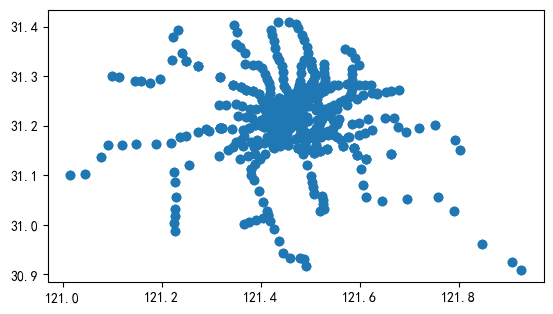

In [152]:
# 从站点经纬度信息生成地理信息列geometry
stop['geometry'] = gpd.points_from_xy(stop['lon'], stop['lat'])
# 将站点数据转换为GeoDataFrame格式
stop = gpd.GeoDataFrame(stop)
# 查看站点分布图
stop.plot()
# 查看站点信息
stop

### 1.2 提取网络轨道边

在前面我提到过地铁网络的边可以抽象为轨道边和换乘边，1.2节操作中我们将从地铁线路和站点数据中提取除相邻站点的信息以构建轨道边。

#### 1.2.1 提取相邻站点构成的轨道边

In [153]:
# 由于站点信息表中，每一行站点信息都按照它们在线路上的顺序排列
# 那么提取相邻站点构成的轨道边只要将表中的站点stationnames列与线路linename列用shift函数整体向上移动一行
stop['linename1'] = stop['linename'].shift(-1)
stop['stationnames1'] = stop['stationnames'].shift(-1)
# 并保留同一条线路的数据即可
stop = stop[stop['linename'] == stop['linename1']]
# 查看站点信息
stop

,stationnames,linename,lon,lat,geometry,linename1,stationnames1
0,富锦路,地铁1号线(富锦路-莘庄),121.420012,31.394078,POINT (121.42001 31.39408),地铁1号线(富锦路-莘庄),友谊西路
1,友谊西路,地铁1号线(富锦路-莘庄),121.423351,31.382958,POINT (121.42335 31.38296),地铁1号线(富锦路-莘庄),宝安公路
2,宝安公路,地铁1号线(富锦路-莘庄),121.426290,31.371680,POINT (121.42629 31.37168),地铁1号线(富锦路-莘庄),共富新村
3,共富新村,地铁1号线(富锦路-莘庄),121.429462,31.356866,POINT (121.42946 31.35687),地铁1号线(富锦路-莘庄),呼兰路
4,呼兰路,地铁1号线(富锦路-莘庄),121.433107,31.341553,POINT (121.43311 31.34155),地铁1号线(富锦路-莘庄),通河新村
...,...,...,...,...,...,...,...
944,沈杜公路,轨道交通浦江线(沈杜公路-汇臻路),121.508229,31.063552,POINT (121.50823 31.06355),轨道交通浦江线(沈杜公路-汇臻路),三鲁公路
945,三鲁公路,轨道交通浦江线(沈杜公路-汇臻路),121.523211,31.058207,POINT (121.52321 31.05821),轨道交通浦江线(沈杜公路-汇臻路),闵瑞路
946,闵瑞路,轨道交通浦江线(沈杜公路-汇臻路),121.526112,31.050321,POINT (121.52611 31.05032),轨道交通浦江线(沈杜公路-汇臻路),浦航路
947,浦航路,轨道交通浦江线(沈杜公路-汇臻路),121.526392,31.043280,POINT (121.52639 31.04328),轨道交通浦江线(沈杜公路-汇臻路),东城一路


#### 1.2.2 站点信息重命名

上面提到如果同一个站点同时属于多条线路，则需要区分开来。而一条地铁线在数据中会存在两个运营方向，并且观察linename列，我们可以发现名称不仅保留了地铁线路名，还保留了方向的信息，而站点名称不包含线路的信息。因此这里最好能够将地铁站点重命名，在该站点名称前面加上该站点所属的线路名称（且线路名称中不包含线路的运行方向），才能够将同一个站点所连接的不同线路区分。

In [154]:
# 提取线路名
stop['line'] = stop['linename'].apply(lambda r: r.split('(')[0].lstrip('地铁'))
# 五号线支线 去掉 支线两个字，使其能够对应
stop.loc[stop['line'] == '5号线支线', 'line'] = '5号线'
# 重命名列名
stop = stop.rename(columns={'stationnames': 'ostop', 'stationnames1': 'dstop'})
# 构建站点名称，使得不同线路不同站点能够区分
stop['ostation'] = stop['line'] + stop['ostop']
stop['dstation'] = stop['line'] + stop['dstop']
# 列太多，转置方便查看
stop.iloc[:3].T

,0,1,2
ostop,富锦路,友谊西路,宝安公路
linename,地铁1号线(富锦路-莘庄),地铁1号线(富锦路-莘庄),地铁1号线(富锦路-莘庄)
lon,121.420012,121.423351,121.42629
lat,31.394078,31.382958,31.37168
geometry,POINT (121.42001197737255 31.39407815119172),POINT (121.42335122582088 31.382957629137486),POINT (121.42628965526124 31.371680039785065)
linename1,地铁1号线(富锦路-莘庄),地铁1号线(富锦路-莘庄),地铁1号线(富锦路-莘庄)
dstop,友谊西路,宝安公路,共富新村
line,1号线,1号线,1号线
ostation,1号线富锦路,1号线友谊西路,1号线宝安公路
dstation,1号线友谊西路,1号线宝安公路,1号线共富新村


#### 1.2.3 构建带有权重的网络轨道边

我们需要给边添加权重，假定地铁搭一个站点耗时3分钟（列车运行时间+停站时间），这个权重的设置其实是很值得探讨的一个内容，它可以根据不同城市、不同时段、不同列车运行区间来进行细分。

In [155]:
# 构建网络边的第一部分，轨道边
edge1 = stop[['ostation', 'dstation']]
# 给轨道边添加权重，假定一个站点耗时3min
edge1['duration'] = 3
# 查看边信息
edge1

,ostation,dstation,duration
0,1号线富锦路,1号线友谊西路,3
1,1号线友谊西路,1号线宝安公路,3
2,1号线宝安公路,1号线共富新村,3
3,1号线共富新村,1号线呼兰路,3
4,1号线呼兰路,1号线通河新村,3
...,...,...,...
944,轨道交通浦江线沈杜公路,轨道交通浦江线三鲁公路,3
945,轨道交通浦江线三鲁公路,轨道交通浦江线闵瑞路,3
946,轨道交通浦江线闵瑞路,轨道交通浦江线浦航路,3
947,轨道交通浦江线浦航路,轨道交通浦江线东城一路,3


### 1.3 提取网络换乘边

在本小节中，我们将构建地铁网络的换乘边，为同一个站点的不同线路之间添加边以代表换乘行为，并以不同线路站台之间的步行时间为边赋权。

#### 1.3.1 重新构建站点信息

重新读取轨道站点数据，并以和构建轨道边相同的方式构建站点名称。

In [156]:
# 重新读取轨道站点数据
stop = pd.read_csv(r'data/stop.csv')
# 提取线路名，构建站点名
stop['line'] = stop['linename'].apply(lambda r: r.split('(')[0].lstrip('地铁'))
stop['station'] = stop['line'] + stop['stationnames']

#### 1.3.2 提取可能可以进行换乘的站点


构建换乘边首先要提取出多条线路交汇、存在换乘可能的站点信息，即计算每个站点在数据中出现了多少次。

In [157]:
# 计算出现次数
tmp = stop.groupby(['stationnames'])[
    'linename'].count().rename('count').reset_index()
# 查看可能的站点
tmp

,stationnames,count
0,七宝,2
1,七莘路,2
2,三林,4
3,三林东,4
4,三门路,4
...,...,...
339,龙柏新村,2
340,龙溪路,4
341,龙漕路,4
342,龙耀路,4


#### 1.3.3 提取真正的换乘站点

为什么上面的站点出现次数都是偶数且最小为2呢？这是因为站点信息表中包含轨道双向的信息，一条轨道线存在双向，也导致站点出现次数是原来的两倍。而出现次数超过2的，则为换乘站点，提取其站点信息。

In [158]:
# 超过两次的换乘站点提取出来
tmp = pd.merge(stop, tmp[tmp['count'] > 2]['stationnames'], on='stationnames')
# 查看换乘站点
tmp

,stationnames,linename,lon,lat,line,station
0,上海火车站,地铁1号线(富锦路-莘庄),121.451347,31.249252,1号线,1号线上海火车站
1,上海火车站,地铁1号线(莘庄-富锦路),121.451347,31.249252,1号线,1号线上海火车站
2,上海火车站,地铁3号线(江杨北路-上海南站),121.453726,31.251608,3号线,3号线上海火车站
3,上海火车站,地铁3号线(上海南站-江杨北路),121.453726,31.251608,3号线,3号线上海火车站
4,上海火车站,地铁4号线(外圈(宜山路-宜山路)),121.453727,31.251607,4号线,4号线上海火车站
...,...,...,...,...,...,...
451,嘉定新城,地铁11号线(迪士尼-花桥),121.250005,31.332072,11号线,11号线嘉定新城
452,华夏中路,地铁13号线(张江路-金运路),121.577279,31.176771,13号线,13号线华夏中路
453,华夏中路,地铁13号线(金运路-张江路),121.577279,31.176771,13号线,13号线华夏中路
454,华夏中路,地铁16号线(龙阳路-滴水湖),121.578983,31.177900,16号线,16号线华夏中路


#### 1.3.4 对同一个站点生成不同线路之间的两两对应表

In [159]:
# 为换乘站构建边
tmp = tmp[['stationnames', 'line', 'station']].drop_duplicates()
# 生成不同线路之间的对应表
tmp = pd.merge(tmp, tmp, on='stationnames')
# 查看表
tmp

,stationnames,line_x,station_x,line_y,station_y
0,上海火车站,1号线,1号线上海火车站,1号线,1号线上海火车站
1,上海火车站,1号线,1号线上海火车站,3号线,3号线上海火车站
2,上海火车站,1号线,1号线上海火车站,4号线,4号线上海火车站
3,上海火车站,3号线,3号线上海火车站,1号线,1号线上海火车站
4,上海火车站,3号线,3号线上海火车站,3号线,3号线上海火车站
...,...,...,...,...,...
365,嘉定新城,11号线,11号线嘉定新城,11号线,11号线嘉定新城
366,华夏中路,13号线,13号线华夏中路,13号线,13号线华夏中路
367,华夏中路,13号线,13号线华夏中路,16号线,16号线华夏中路
368,华夏中路,16号线,16号线华夏中路,13号线,13号线华夏中路


#### 1.3.5 获取建图数据

去重并提取换乘边，然后给边赋上5min的权重（不同站台之间的步行时间）。

In [160]:
# 提取信息
edge2 = tmp[tmp['line_x'] != tmp['line_y']][['station_x', 'station_y']]
# 设置起点终点
edge2.columns = ['ostation', 'dstation']
# 加时间
edge2['duration'] = 5
# 查看换乘边
edge2

,ostation,dstation,duration
1,1号线上海火车站,3号线上海火车站,5
2,1号线上海火车站,4号线上海火车站,5
3,3号线上海火车站,1号线上海火车站,5
5,3号线上海火车站,4号线上海火车站,5
6,4号线上海火车站,1号线上海火车站,5
...,...,...,...
343,16号线罗山路,11号线罗山路,5
353,11号线隆德路,13号线隆德路,5
354,13号线隆德路,11号线隆德路,5
367,13号线华夏中路,16号线华夏中路,5


### 1.4 构建网络

#### 1.4.1 提取节点信息

将轨道边和换乘边的数据合并，以起点、终点和权重三列的方式存储，并提取出节点信息，以名字列表方式存储。

In [161]:
# 将两类合并
edge = edge1.append(edge2)
# 提取其中的节点
node = list(edge['ostation'].drop_duplicates())
# 查看边
print(edge)
# 查看节点
print(node)

     ostation  dstation  duration
0      1号线富锦路   1号线友谊西路         3
1     1号线友谊西路   1号线宝安公路         3
2     1号线宝安公路   1号线共富新村         3
3     1号线共富新村    1号线呼兰路         3
4      1号线呼兰路   1号线通河新村         3
..        ...       ...       ...
343   16号线罗山路   11号线罗山路         5
353   11号线隆德路   13号线隆德路         5
354   13号线隆德路   11号线隆德路         5
367  13号线华夏中路  16号线华夏中路         5
368  16号线华夏中路  13号线华夏中路         5

[1106 rows x 3 columns]
['1号线富锦路', '1号线友谊西路', '1号线宝安公路', '1号线共富新村', '1号线呼兰路', '1号线通河新村', '1号线共康路', '1号线彭浦新村', '1号线汶水路', '1号线上海马戏城', '1号线延长路', '1号线中山北路', '1号线上海火车站', '1号线汉中路', '1号线新闸路', '1号线人民广场', '1号线黄陂南路', '1号线陕西南路', '1号线常熟路', '1号线衡山路', '1号线徐家汇', '1号线上海体育馆', '1号线漕宝路', '1号线上海南站', '1号线锦江乐园', '1号线莲花路', '1号线外环路', '1号线莘庄', '2号线徐泾东', '2号线虹桥火车站', '2号线虹桥2号航站楼', '2号线淞虹路', '2号线北新泾', '2号线威宁路', '2号线娄山关路', '2号线中山公园', '2号线江苏路', '2号线静安寺', '2号线南京西路', '2号线人民广场', '2号线南京东路', '2号线陆家嘴', '2号线东昌路', '2号线世纪大道', '2号线上海科技馆', '2号线世纪公园', '2号线龙阳路', '2号线张江高科', '2号线金科路', '2号线广兰路', '2号线唐镇', '2号线创新中路', '2号线华夏东路', '2号

#### 1.4.2 创建网络

利用NetworkX创建网络，将节点和边添加至网络中，然后绘制网络图，查看网络是否创建成功。

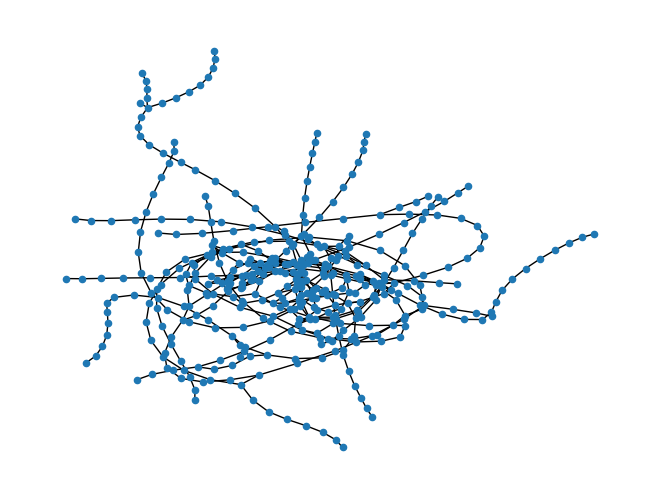

In [162]:
# 先创建一个空网络
G = nx.Graph()
# 添加节点
G.add_nodes_from(node)
# 添加含有权重的无向边，自动将前两列视为起点和终点，将第三列识别为权重
G.add_weighted_edges_from(edge.values)
# 绘制网络草图，注意这个图每一次绘制都不一样
nx.draw(G, node_size=20)

#### 1.4.3 检查网络

在构建好的网络上，利用NetworkX中的shortest_path方法测试是否能够依据最短路径获取出行路径信息。

In [163]:
# tips：这是我之前在计科的时候从中北到机场的路线
# 输入起点和终点信息并规定权重
nx.shortest_path(G, source='3号线金沙江路', target='2号线浦东国际机场', weight='weight')

['3号线金沙江路',
 '3号线中山公园',
 '2号线中山公园',
 '2号线江苏路',
 '2号线静安寺',
 '2号线南京西路',
 '2号线人民广场',
 '2号线南京东路',
 '2号线陆家嘴',
 '2号线东昌路',
 '2号线世纪大道',
 '2号线上海科技馆',
 '2号线世纪公园',
 '2号线龙阳路',
 '2号线张江高科',
 '2号线金科路',
 '2号线广兰路',
 '2号线唐镇',
 '2号线创新中路',
 '2号线华夏东路',
 '2号线川沙',
 '2号线凌空路',
 '2号线远东大道',
 '2号线海天三路',
 '2号线浦东国际机场']

## 2 地铁出行路径提取

在这一个小节中，我将从IC刷卡数据中提取出出行OD信息，并利用前面构建的地铁网络获取每一条OD数据的出行路径，从而实现将出行客流分配到网络上，用于后面的断面客流特征分析和可视化。

### 2.1 提取IC刷卡数据中的OD信息

#### 2.1.1 读取IC刷卡数据

In [164]:
icdata = pd.read_csv(r'data/icdata-sample.csv', header=None)
# 给每一个列赋予名
icdata.columns = ['cardid', 'date', 'time', 'station', 'mode', 'price', 'type']
# 查看数据
icdata

,cardid,date,time,station,mode,price,type
0,100405844,2015-04-01,12:43:24,11号线祁连山路,地铁,4.0,非优惠
1,100405844,2015-04-01,18:22:04,11号线枫桥路,地铁,3.0,非优惠
2,100405844,2015-04-01,08:21:18,2号线娄山关路,地铁,3.0,非优惠
3,100405844,2015-04-01,12:07:31,2号线娄山关路,地铁,0.0,非优惠
4,100405844,2015-04-01,18:08:42,11号线祁连山路,地铁,0.0,非优惠
...,...,...,...,...,...,...,...
442855,2301108266,2015-04-01,23:48:21,2号线中山公园,地铁,4.0,非优惠
442856,2301108266,2015-04-01,23:06:45,2号线虹桥火车站,地铁,0.0,非优惠
442857,2104162123,2015-04-01,23:48:07,2号线中山公园,地铁,4.0,非优惠
442858,2104162123,2015-04-01,23:18:16,2号线虹桥火车站,地铁,0.0,非优惠


#### 2.1.2 提取地铁出行部分

提取地铁出行部分，然后按卡号与时间顺序对数据进行排序，然后将数据的各列整体地往上移动一行，赋值给新的列，然后筛选出其中卡号与下一条卡号相同，且刷卡金额为0，下一条刷卡金额不为0的记录（每次地铁出行存在两次刷卡，进站时金额为0，出站时金额不为0），最后提取有用信息并存储OD结果。

In [165]:
# 提取其中地铁刷卡部分
metrodata = icdata[icdata['mode'] == '地铁']
# 按卡号时间排序
metrodata = metrodata.sort_values(by=['cardid', 'date', 'time'])
# 将数据整体往上移一行赋值给新的列
for i in metrodata.columns:
    metrodata[i + '1'] = metrodata[i].shift(-1)
# 每条出行只保留一条记录
metrood = metrodata[(metrodata['cardid'] == metrodata['cardid1']) &
                    (metrodata['price'] == 0) &
                    (metrodata['price1'] > 0)]
# 提取起终点的线路和站点
metrood['oline'] = metrood['station'].apply(lambda r: r[:(r.find('线') + 1)])
metrood['ostation'] = metrood['station'].apply(lambda r: r[(r.find('线') + 1):])
metrood['dline'] = metrood['station1'].apply(lambda r: r[:(r.find('线') + 1)])
metrood['dstation'] = metrood['station1'].apply(lambda r: r[(r.find('线') + 1):])
# 保留有用的列，并重命名列
metrood = metrood[['cardid', 'date', 'time', 'station', 'oline',
                   'ostation', 'time1', 'station1', 'dline', 'dstation']]
metrood.columns = ['cardid', 'date', 'otime', 'ostation',
                   'oline', 'ostop', 'dtime', 'dstation', 'dline', 'dstop']
# 保存OD数据
metrood.to_csv(r'data/metrood.csv', index=None, encoding='utf-8_sig')
# 列太多，转置方便查看
# 输出结果如下所示，包含每一次地铁出行的卡号，进站时间、进站站点、进站线路、出站时间、出站站点、出站线路等信息
metrood.iloc[:5].T

,334427,381022,376286,376285,6062
cardid,82024,88957,99313,99313,116435
date,2015-04-01,2015-04-01,2015-04-01,2015-04-01,2015-04-01
otime,08:48:25,15:46:58,08:26:26,18:09:51,12:24:49
ostation,8号线西藏北路,3号线宜山路,8号线延吉中路,9号线打浦桥,4号线大连路
oline,8号线,3号线,8号线,9号线,4号线
ostop,西藏北路,宜山路,延吉中路,打浦桥,大连路
dtime,09:07:29,16:20:58,09:07:27,18:46:06,12:56:16
dstation,10号线江湾体育场,3号线东宝兴路,9号线打浦桥,8号线延吉中路,3号线中山公园
dline,10号线,3号线,9号线,8号线,3号线
dstop,江湾体育场,东宝兴路,打浦桥,延吉中路,中山公园


### 2.2 出行路径提取

接下来我们需要对每一行OD数据提取出它们在地铁网中的出行路径信息。

#### 2.2.1 修改站点名称

对于部分地铁站点来说，刷卡数据中提取出来的OD信息与地铁线路网数据中的地铁站名称有差异，我们先对OD信息中的站点名称进行修正，使其与地铁网络中的站点对应。

In [166]:
# 修改OD数据的站点名称，使其能够与GIS数据构建的网络中的站点名称对应
metrood.loc[metrood['ostop'] == '淞浜路', 'ostop'] = '淞滨路'
metrood.loc[metrood['dstop'] == '淞浜路', 'dstop'] = '淞滨路'
metrood.loc[metrood['ostop'] == '上海大学站', 'ostop'] = '上海大学'
metrood.loc[metrood['dstop'] == '上海大学站', 'dstop'] = '上海大学'
metrood.loc[metrood['ostop'] == '上海野生动物园', 'ostop'] = '野生动物园'
metrood.loc[metrood['dstop'] == '上海野生动物园', 'dstop'] = '野生动物园'
metrood.loc[metrood['ostop'] == '外高桥保税区北', 'ostop'] = '外高桥保税区北站'
metrood.loc[metrood['dstop'] == '外高桥保税区北', 'dstop'] = '外高桥保税区北站'
metrood.loc[metrood['ostop'] == '外高桥保税区南', 'ostop'] = '外高桥保税区南站'
metrood.loc[metrood['dstop'] == '外高桥保税区南', 'dstop'] = '外高桥保税区南站'
metrood.loc[metrood['ostop'] == '李子园路', 'ostop'] = '李子园'
metrood.loc[metrood['dstop'] == '李子园路', 'dstop'] = '李子园'
# 字符串左右去除空格
metrood['ostop'] = metrood['ostop'].str.lstrip(' ').str.rstrip(' ')
metrood['dstop'] = metrood['dstop'].str.lstrip(' ').str.rstrip(' ')
# 构建修正后的站点名称（带线路名称）
metrood['ostation'] = metrood['oline'] + metrood['ostop']
metrood['dstation'] = metrood['dline'] + metrood['dstop']

#### 2.2.2 对OD数据去重

在获取出行路径前，先对OD数据进行去重。因为对于上面的OD数据，每一次出行都是一次记录，而这些记录的起点终点都是重复的，我们只需要对每一对OD获取一次出行路径即可，以减少计算量。

In [167]:
# 获取去重后的OD
od_distinct = metrood[['ostation', 'dstation']].drop_duplicates()
# 查看OD
od_distinct

,ostation,dstation
334427,8号线西藏北路,10号线江湾体育场
381022,3号线宜山路,3号线东宝兴路
376286,8号线延吉中路,9号线打浦桥
376285,9号线打浦桥,8号线延吉中路
6062,4号线大连路,3号线中山公园
...,...,...
219518,2号线海天三路,2号线中山公园
343225,11号线嘉定西,10号线宋园路
278184,10号线同济大学,8号线市光路
263862,5号线北桥,11号线江苏路


#### 2.2.3 对去重后的OD表提取出行路径

先取出第一行记录测试能否获取出行路径。

In [168]:
r = od_distinct.iloc[0]
nx.shortest_path(G, source=r['ostation'],
                 target=r['dstation'],
                 weight='weight')

['8号线西藏北路',
 '8号线虹口足球场',
 '8号线曲阳路',
 '8号线四平路',
 '10号线四平路',
 '10号线同济大学',
 '10号线国权路',
 '10号线五角场',
 '10号线江湾体育场']

遍历去重后的OD表中的每一行，对每一对OD数据获取最短出行路径。

In [169]:
od_distinct['path'] = od_distinct.apply(
    lambda r: nx.shortest_path(G, source=r['ostation'],
                               target=r['dstation'],
                               weight='weight'), axis=1)
# 查看结果
od_distinct

,ostation,dstation,path
334427,8号线西藏北路,10号线江湾体育场,"[8号线西藏北路, 8号线虹口足球场, 8号线曲阳路, 8号线四平路, 10号线四平路, 1..."
381022,3号线宜山路,3号线东宝兴路,"[3号线宜山路, 3号线虹桥路, 3号线延安西路, 3号线中山公园, 3号线金沙江路, 3号..."
376286,8号线延吉中路,9号线打浦桥,"[8号线延吉中路, 8号线黄兴路, 8号线江浦路, 8号线鞍山新村, 8号线四平路, 8号线..."
376285,9号线打浦桥,8号线延吉中路,"[9号线打浦桥, 9号线马当路, 9号线陆家浜路, 8号线陆家浜路, 8号线老西门, 8号线..."
6062,4号线大连路,3号线中山公园,"[4号线大连路, 4号线临平路, 4号线海伦路, 4号线宝山路, 4号线上海火车站, 3号线..."
...,...,...,...
219518,2号线海天三路,2号线中山公园,"[2号线海天三路, 2号线远东大道, 2号线凌空路, 2号线川沙, 2号线华夏东路, 2号线..."
343225,11号线嘉定西,10号线宋园路,"[11号线嘉定西, 11号线白银路, 11号线嘉定新城, 11号线马陆, 11号线南翔, 1..."
278184,10号线同济大学,8号线市光路,"[10号线同济大学, 10号线四平路, 8号线四平路, 8号线鞍山新村, 8号线江浦路, 8..."
263862,5号线北桥,11号线江苏路,"[5号线北桥, 5号线颛桥, 5号线银都路, 5号线春申路, 5号线莘庄, 1号线莘庄, 1..."


#### 2.2.4 出行路径数据格式变换

上面得到的od_distinct表不利于pandas运算，因为每一条路径的出行信息都在一行中了，每一行的长度都不一样，一行记录中包含多个点的路径信息。我们需要把OD数据展开成如下的出行路径信息表，即o和d是当前经过的路径的路径段的前后两个地铁站，ostation和dstation是所在路径的起终点，即把原先od_distinct表中的一行数据拆成多行数据，这时候的每一行数据就是轨道出行路径中的一个断面。例如“A->B->C->D”转换为“A->B”、“B->C”、“C->D”。

注意，下面的代码块将是导致本项目执行时间较久的唯一因素，因为它要处理60多万条数据，请耐心等待。

In [170]:
# 先创建空的list
ls = []
# 遍历
for i in range(len(od_distinct)):
    # 获取其中的一行
    r = od_distinct.iloc[i]
    # 对这一行的路径构建轨道段的表
    tmp = pd.DataFrame(r['path'], columns=['o'])
    tmp['d'] = tmp['o'].shift(-1)
    tmp = tmp.iloc[:-1]
    # 对这个表添加多两列
    tmp['ostation'] = r['ostation']
    tmp['dstation'] = r['dstation']
    # 将这个表添加到空list里
    ls.append(tmp)
# 合并list里面的表，变成一个大的出行路径表，这个表存储了O和D以及它经过的轨道段
od_path = pd.concat(ls)
# 保存
od_path.to_csv(r'data/od_path.csv', index=None, encoding='utf-8_sig')
# 查看新表
od_path

,o,d,ostation,dstation
0,8号线西藏北路,8号线虹口足球场,8号线西藏北路,10号线江湾体育场
1,8号线虹口足球场,8号线曲阳路,8号线西藏北路,10号线江湾体育场
2,8号线曲阳路,8号线四平路,8号线西藏北路,10号线江湾体育场
3,8号线四平路,10号线四平路,8号线西藏北路,10号线江湾体育场
4,10号线四平路,10号线同济大学,8号线西藏北路,10号线江湾体育场
...,...,...,...,...
11,10号线四平路,10号线同济大学,9号线小南门,10号线三门路
12,10号线同济大学,10号线国权路,9号线小南门,10号线三门路
13,10号线国权路,10号线五角场,9号线小南门,10号线三门路
14,10号线五角场,10号线江湾体育场,9号线小南门,10号线三门路


## 3 轨道断面客流分布可视化

2.2.4中生成的od_path是本节中较为关键的一张表，记录了每一对OD的路径信息，有了它就能将出行OD转化为断面客流。本节以早上8点为例，提取早上8点进站的所有信息，进行断面客流的统计，并绘制2号线8点断面客流柱状图。

### 3.1 统计断面客流

#### 3.1.1 提取早上8时进站的所有地铁出行信息进行断面客流统计

In [171]:
# 为OD添加小时的列
metrood['Hour'] = metrood['otime'].apply(lambda r: r.split(':')[0])
# 提取8点的OD，并将OD与出行路径表连接
trips_08 = metrood[metrood['Hour'] == '08']
# 查看早上8时进站的出行记录
trips_08

,cardid,date,otime,ostation,oline,ostop,dtime,dstation,dline,dstop,Hour
334427,82024,2015-04-01,08:48:25,8号线西藏北路,8号线,西藏北路,09:07:29,10号线江湾体育场,10号线,江湾体育场,08
376286,99313,2015-04-01,08:26:26,8号线延吉中路,8号线,延吉中路,09:07:27,9号线打浦桥,9号线,打浦桥,08
72139,130541,2015-04-01,08:17:57,2号线金科路,2号线,金科路,08:55:54,4号线浦电路,4号线,浦电路,08
282582,144982,2015-04-01,08:51:00,5号线金平路,5号线,金平路,09:02:02,5号线闵行开发区,5号线,闵行开发区,08
292397,160245,2015-04-01,08:08:01,2号线川沙,2号线,川沙,09:01:45,10号线南京东路,10号线,南京东路,08
...,...,...,...,...,...,...,...,...,...,...,...
279390,4000018517,2015-04-01,08:17:41,7号线杨高南路,7号线,杨高南路,08:58:08,13号线武宁路,13号线,武宁路,08
67233,4000021245,2015-04-01,08:10:16,8号线虹口足球场,8号线,虹口足球场,08:38:33,9号线打浦桥,9号线,打浦桥,08
435290,4000032350,2015-04-01,08:30:56,9号线中春路,9号线,中春路,08:44:55,9号线漕河泾开发区,9号线,漕河泾开发区,08
234888,4000038121,2015-04-01,08:19:28,13号线金运路,13号线,金运路,09:05:42,1号线人民广场,1号线,人民广场,08


#### 3.1.2 将上面的出行数据与od_path表连接，将OD信息转化为断面信息。

In [172]:
# 提取8点的OD，并将OD与出行路径表连接
tmp = pd.merge(trips_08, od_path, on=['ostation', 'dstation'])
# 列太多，转置方便查看断面信息
tmp.iloc[:5].T

,0,1,2,3,4
cardid,82024,82024,82024,82024,82024
date,2015-04-01,2015-04-01,2015-04-01,2015-04-01,2015-04-01
otime,08:48:25,08:48:25,08:48:25,08:48:25,08:48:25
ostation,8号线西藏北路,8号线西藏北路,8号线西藏北路,8号线西藏北路,8号线西藏北路
oline,8号线,8号线,8号线,8号线,8号线
ostop,西藏北路,西藏北路,西藏北路,西藏北路,西藏北路
dtime,09:07:29,09:07:29,09:07:29,09:07:29,09:07:29
dstation,10号线江湾体育场,10号线江湾体育场,10号线江湾体育场,10号线江湾体育场,10号线江湾体育场
dline,10号线,10号线,10号线,10号线,10号线
dstop,江湾体育场,江湾体育场,江湾体育场,江湾体育场,江湾体育场


#### 3.1.3 统计8点进站的断面客流

In [173]:
# 得到每个轨道段的客流量
metro_passenger = tmp.groupby(
    ['o', 'd'])['cardid'].count().rename('count').reset_index()
# 查看客流量
metro_passenger

,o,d,count
0,10号线三门路,10号线殷高东路,8
1,10号线三门路,10号线江湾体育场,91
2,10号线上海动物园,10号线虹桥1号航站楼,69
3,10号线上海动物园,10号线龙溪路,115
4,10号线上海图书馆,10号线交通大学,256
...,...,...,...
892,9号线陆家浜路,9号线小南门,490
893,9号线陆家浜路,9号线马当路,471
894,9号线马当路,13号线马当路,18
895,9号线马当路,9号线打浦桥,452


### 3.2 绘制断面客流柱状图

在本小节中，我将会使用前面所计算的断面客流数据绘制轨道交通2号线早上8点的断面客流的柱状图。

#### 3.2.1 构建2号线的轨道断面信息表

断面客流柱状图的绘制需要考虑双向的客流情况，一般会将坐标系的x轴作为断面，y轴正负作为该断面的双向客流。因此在绘制断面客流之前，首先要绘制一个表格存储断面信息，表格中的每一行记录是一个断面。在后续的绘图中，只需要将双向客流对应到相应的断面上，再绘制成柱状图即可。

下面是地铁2号线轨道断面信息表的构建过程。

In [174]:
# 指定线路
linename = '2号线'
linestop = stop[stop['line'] == linename]
# 构建轨道断面
for i in linestop.columns:
    linestop[i + '1'] = linestop[i].shift(-1)
linestop = linestop[linestop['linename'] == linestop['linename1']]
# 构建断面名称，使其与集计数据能够对应
linestop = linestop[['stationnames', 'stationnames1', 'linename', 'line1']]
linestop['o'] = linestop['line1'] + linestop['stationnames']
linestop['d'] = linestop['line1'] + linestop['stationnames1']
linestop = linestop[['o', 'd', 'stationnames',
                     'stationnames1', 'linename', 'line1']]
# 查看地铁2号线轨道断面信息表
linestop

,o,d,stationnames,stationnames1,linename,line1
56,2号线徐泾东,2号线虹桥火车站,徐泾东,虹桥火车站,地铁2号线(徐泾东-浦东国际机场),2号线
57,2号线虹桥火车站,2号线虹桥2号航站楼,虹桥火车站,虹桥2号航站楼,地铁2号线(徐泾东-浦东国际机场),2号线
58,2号线虹桥2号航站楼,2号线淞虹路,虹桥2号航站楼,淞虹路,地铁2号线(徐泾东-浦东国际机场),2号线
59,2号线淞虹路,2号线北新泾,淞虹路,北新泾,地铁2号线(徐泾东-浦东国际机场),2号线
60,2号线北新泾,2号线威宁路,北新泾,威宁路,地铁2号线(徐泾东-浦东国际机场),2号线
61,2号线威宁路,2号线娄山关路,威宁路,娄山关路,地铁2号线(徐泾东-浦东国际机场),2号线
62,2号线娄山关路,2号线中山公园,娄山关路,中山公园,地铁2号线(徐泾东-浦东国际机场),2号线
63,2号线中山公园,2号线江苏路,中山公园,江苏路,地铁2号线(徐泾东-浦东国际机场),2号线
64,2号线江苏路,2号线静安寺,江苏路,静安寺,地铁2号线(徐泾东-浦东国际机场),2号线
65,2号线静安寺,2号线南京西路,静安寺,南京西路,地铁2号线(徐泾东-浦东国际机场),2号线


#### 3.2.2 将客流与断面进行匹配

需要注意的是，在站点表中同时存在轨道双向的站点信息，因此目前得到的轨道断面信息表也包含双向的断面。例如上表中将“徐泾东”到“虹桥火车站”与“虹桥火车站”到“徐泾东”这同一个断面的双向是为两个不同的断面。这样将断面的双向分开后，才能够将双向的客流都从3.1.3得到的metro_passenger断面客流集计表中找到对应。

In [175]:
# 匹配断面客流
linestop = pd.merge(linestop, metro_passenger, on=['o', 'd'])
# 查看断面客流量
linestop

,o,d,stationnames,stationnames1,linename,line1,count
0,2号线徐泾东,2号线虹桥火车站,徐泾东,虹桥火车站,地铁2号线(徐泾东-浦东国际机场),2号线,237
1,2号线虹桥火车站,2号线虹桥2号航站楼,虹桥火车站,虹桥2号航站楼,地铁2号线(徐泾东-浦东国际机场),2号线,307
2,2号线虹桥2号航站楼,2号线淞虹路,虹桥2号航站楼,淞虹路,地铁2号线(徐泾东-浦东国际机场),2号线,311
3,2号线淞虹路,2号线北新泾,淞虹路,北新泾,地铁2号线(徐泾东-浦东国际机场),2号线,571
4,2号线北新泾,2号线威宁路,北新泾,威宁路,地铁2号线(徐泾东-浦东国际机场),2号线,755
5,2号线威宁路,2号线娄山关路,威宁路,娄山关路,地铁2号线(徐泾东-浦东国际机场),2号线,838
6,2号线娄山关路,2号线中山公园,娄山关路,中山公园,地铁2号线(徐泾东-浦东国际机场),2号线,943
7,2号线中山公园,2号线江苏路,中山公园,江苏路,地铁2号线(徐泾东-浦东国际机场),2号线,999
8,2号线江苏路,2号线静安寺,江苏路,静安寺,地铁2号线(徐泾东-浦东国际机场),2号线,1332
9,2号线静安寺,2号线南京西路,静安寺,南京西路,地铁2号线(徐泾东-浦东国际机场),2号线,1440


#### 3.2.3 提取上行断面客流信息

将同一个双向的断面客流信息区分为上行与下行两个表，再为上行与下行的相同断面加上同一编号，使其能够对应，首先构建上行断面的信息。

In [176]:
# 提取上行客流
# 上行线路名称
shangxing = linestop['linename'].drop_duplicates().iloc[0]
# 筛选上行断面
tmp = linestop[linestop['linename'] == shangxing]
# 为上行断面编号
tmp['x'] = range(len(tmp))
# 查看上行的断面客流信息
tmp

,o,d,stationnames,stationnames1,linename,line1,count,x
0,2号线徐泾东,2号线虹桥火车站,徐泾东,虹桥火车站,地铁2号线(徐泾东-浦东国际机场),2号线,237,0
1,2号线虹桥火车站,2号线虹桥2号航站楼,虹桥火车站,虹桥2号航站楼,地铁2号线(徐泾东-浦东国际机场),2号线,307,1
2,2号线虹桥2号航站楼,2号线淞虹路,虹桥2号航站楼,淞虹路,地铁2号线(徐泾东-浦东国际机场),2号线,311,2
3,2号线淞虹路,2号线北新泾,淞虹路,北新泾,地铁2号线(徐泾东-浦东国际机场),2号线,571,3
4,2号线北新泾,2号线威宁路,北新泾,威宁路,地铁2号线(徐泾东-浦东国际机场),2号线,755,4
5,2号线威宁路,2号线娄山关路,威宁路,娄山关路,地铁2号线(徐泾东-浦东国际机场),2号线,838,5
6,2号线娄山关路,2号线中山公园,娄山关路,中山公园,地铁2号线(徐泾东-浦东国际机场),2号线,943,6
7,2号线中山公园,2号线江苏路,中山公园,江苏路,地铁2号线(徐泾东-浦东国际机场),2号线,999,7
8,2号线江苏路,2号线静安寺,江苏路,静安寺,地铁2号线(徐泾东-浦东国际机场),2号线,1332,8
9,2号线静安寺,2号线南京西路,静安寺,南京西路,地铁2号线(徐泾东-浦东国际机场),2号线,1440,9


#### 3.2.4 提取下行断面客流信息

In [177]:
# 提取下行客流
# 下行线路名称
xiaxing = linestop['linename'].drop_duplicates().iloc[1]
# 筛选下行断面
tmp1 = linestop[linestop['linename'] == xiaxing]
# 为下行断面编号
tmp1['x'] = range(len(tmp1))
# 为下行编号反序，使其能够与上行断面对应
tmp1['x'] = len(tmp1) - tmp1['x'] - 1
# 查看下行的断面客流信息
tmp1

,o,d,stationnames,stationnames1,linename,line1,count,x
29,2号线浦东国际机场,2号线海天三路,浦东国际机场,海天三路,地铁2号线(浦东国际机场-徐泾东),2号线,20,28
30,2号线海天三路,2号线远东大道,海天三路,远东大道,地铁2号线(浦东国际机场-徐泾东),2号线,23,27
31,2号线远东大道,2号线凌空路,远东大道,凌空路,地铁2号线(浦东国际机场-徐泾东),2号线,25,26
32,2号线凌空路,2号线川沙,凌空路,川沙,地铁2号线(浦东国际机场-徐泾东),2号线,42,25
33,2号线川沙,2号线华夏东路,川沙,华夏东路,地铁2号线(浦东国际机场-徐泾东),2号线,144,24
34,2号线华夏东路,2号线创新中路,华夏东路,创新中路,地铁2号线(浦东国际机场-徐泾东),2号线,228,23
35,2号线创新中路,2号线唐镇,创新中路,唐镇,地铁2号线(浦东国际机场-徐泾东),2号线,241,22
36,2号线唐镇,2号线广兰路,唐镇,广兰路,地铁2号线(浦东国际机场-徐泾东),2号线,378,21
37,2号线广兰路,2号线金科路,广兰路,金科路,地铁2号线(浦东国际机场-徐泾东),2号线,656,20
38,2号线金科路,2号线张江高科,金科路,张江高科,地铁2号线(浦东国际机场-徐泾东),2号线,707,19


#### 3.2.5 提取地铁线路的站点名称

提取出2号线上站点名，以便于绘制断面客流柱状图时进行x轴的标注。

In [178]:
# 提取站点名称
stationnames = list(tmp['stationnames'])
stationnames.append(tmp['stationnames1'].iloc[-1])
# 查看站点
stationnames

['徐泾东',
 '虹桥火车站',
 '虹桥2号航站楼',
 '淞虹路',
 '北新泾',
 '威宁路',
 '娄山关路',
 '中山公园',
 '江苏路',
 '静安寺',
 '南京西路',
 '人民广场',
 '南京东路',
 '陆家嘴',
 '东昌路',
 '世纪大道',
 '上海科技馆',
 '世纪公园',
 '龙阳路',
 '张江高科',
 '金科路',
 '广兰路',
 '唐镇',
 '创新中路',
 '华夏东路',
 '川沙',
 '凌空路',
 '远东大道',
 '海天三路',
 '浦东国际机场']

#### 3.2.6客流量扩大

数据来源是原始数据中抽样获得的1/25，所以将上下行客流量扩大25倍。

In [179]:
tmp['count'] *= 25
tmp1['count'] *= 25

#### 3.2.7 绘制轨道2号线早8点客流断面柱状图

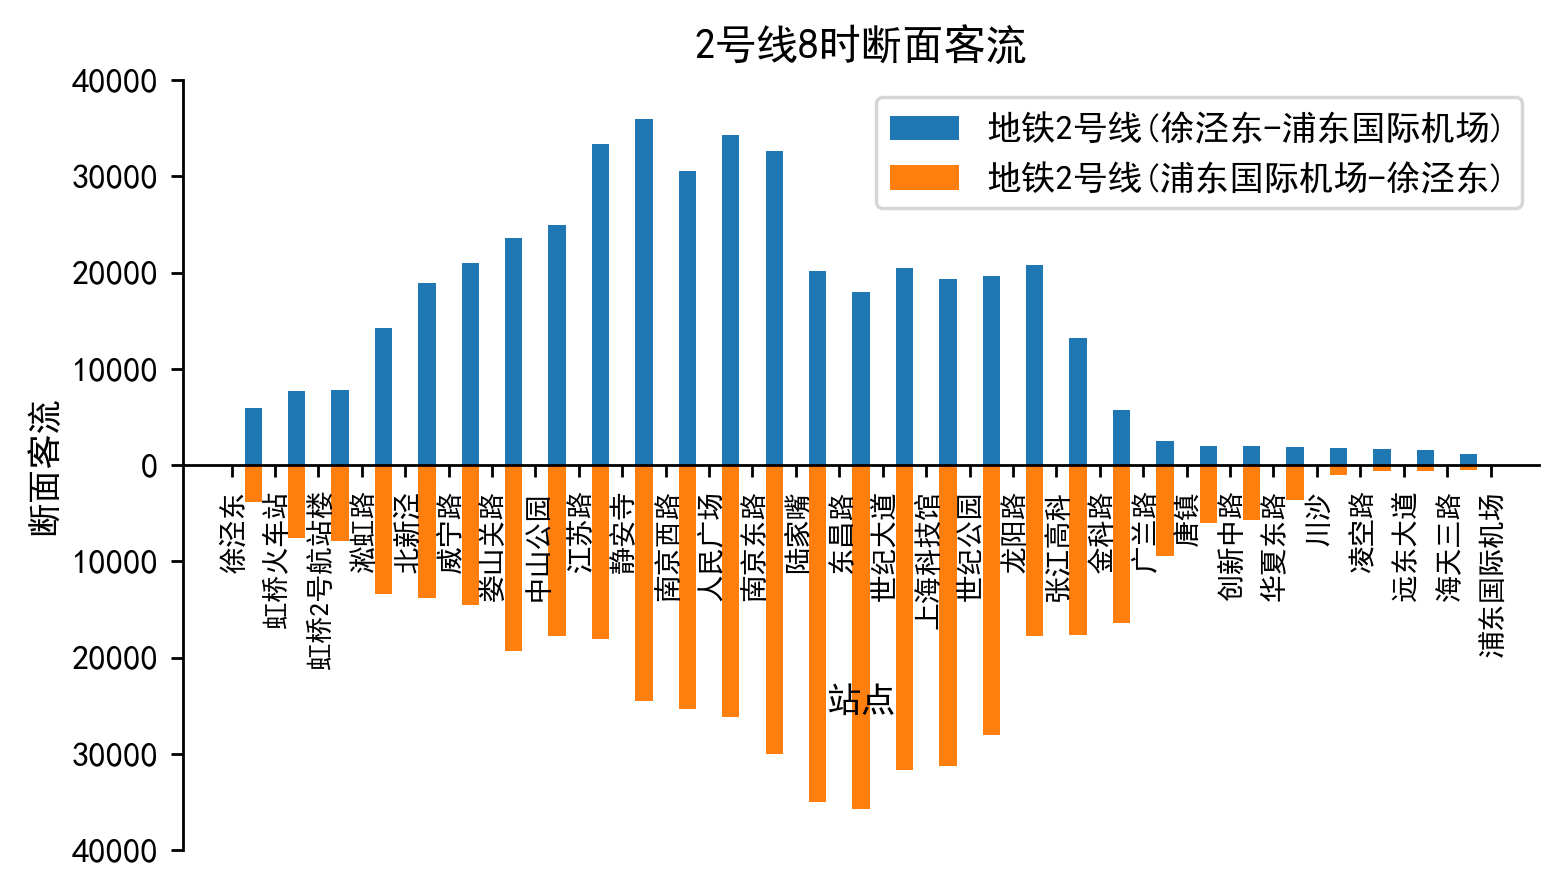

In [180]:
# 绘图
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

fig = plt.figure(1, (7, 4), dpi=250)
ax1 = plt.subplot(111)

# 绘制上下行断面客流
plt.bar(tmp['x'], tmp['count'], width=0.4, label=shangxing)
plt.bar(tmp1['x'], -tmp1['count'], width=0.4, label=xiaxing)

# 图框上轴、右轴不显示，图框的下轴放在y轴为0的地方
ax1.spines['bottom'].set_position(('data', 0))
ax1.spines['top'].set_color('none')
ax1.spines['right'].set_color('none')

# 标注站点名称
plt.xticks(np.arange(len(stationnames)) - 0.5, stationnames, rotation=90, size=8)

# 图例显示与xy轴标题
plt.legend()
plt.ylabel('断面客流')
plt.xlabel('站点')

# 调整y轴显示刻度，不显示负号
locs, labels = plt.yticks()
plt.yticks(locs, abs(locs.astype(int)))

# 定义图名
plt.title(linename + '8时断面客流')
plt.show()

## 4 轨道断面客流蛛网图可视化

在3.2.7节中我们将断面客流分布的结果以柱状图的形式进行了可视化，但柱状图进行可视化的时候，并没有包含站点的空间信息，无法得知地图上的哪一部分区域的客流量最大，作为一个地理人，它是不够的，我们需要在地图上反应出断面客流的分布情况。因此，我们选择通过绘制地铁客流“蛛网图”的形式来将地理空间信息和客流数据相结合。蛛网图的特点是能够将断面客流直观地显示在地图上，将轨道的双向客流区分开来，用线的粗细或者颜色来表达客流量的大小。

我们目前已经有地铁线路、站点的GIS数据和轨道双向的客流量。我们首先要将轨道线路的线型在轨道站点处切分，生成每一个断面的线型地理信息。下一步是将轨道断面的双向客流分别在轨道线路的两边进行显示。这一个步骤有如下两种思路：

1. 在轨道线路的两边生成面，以面的宽度和面的颜色来显示客流量。
2. 在轨道线路的两边生成线，并以线段的粗细和颜色来表示客流量。

对比这两种思路，生成线的思路显然要比生成面的思路简单，在生成线的时候只需要将切分出来的轨道断面往两侧平移，而在生成面时还需要构造面的多条边。因此这里采用生成线的思路。

### 4.1 生成轨道断面线型

#### 4.1.1 读取并整理轨道线型数据

在切分轨道线型之前，首先需要整理好轨道的站点与线型的地理空间信息。我们在这里读取站点数据，并整理为GeoDataFrame。

In [181]:
# 读取轨道站点数据
stop = pd.read_csv(r'data/stop.csv')
# 为站点生成geometry列，存储地理信息
stop['geometry'] = gpd.points_from_xy(stop['lon'], stop['lat'])
# 将站点信息由DataFrame转化为GeoDataFrame
stop = gpd.GeoDataFrame(stop)
# 获取地铁线路名称
stop['line'] = stop['linename'].apply(lambda r: r.split('(')[0])
# 更改地铁5号线支线的名称
stop.loc[stop['line'] == '地铁5号线支线', 'line'] = '地铁5号线'
# 查看站点数据
stop

,stationnames,linename,lon,lat,geometry,line
0,富锦路,地铁1号线(富锦路-莘庄),121.420012,31.394078,POINT (121.42001 31.39408),地铁1号线
1,友谊西路,地铁1号线(富锦路-莘庄),121.423351,31.382958,POINT (121.42335 31.38296),地铁1号线
2,宝安公路,地铁1号线(富锦路-莘庄),121.426290,31.371680,POINT (121.42629 31.37168),地铁1号线
3,共富新村,地铁1号线(富锦路-莘庄),121.429462,31.356866,POINT (121.42946 31.35687),地铁1号线
4,呼兰路,地铁1号线(富锦路-莘庄),121.433107,31.341553,POINT (121.43311 31.34155),地铁1号线
...,...,...,...,...,...,...
945,三鲁公路,轨道交通浦江线(沈杜公路-汇臻路),121.523211,31.058207,POINT (121.52321 31.05821),轨道交通浦江线
946,闵瑞路,轨道交通浦江线(沈杜公路-汇臻路),121.526112,31.050321,POINT (121.52611 31.05032),轨道交通浦江线
947,浦航路,轨道交通浦江线(沈杜公路-汇臻路),121.526392,31.043280,POINT (121.52639 31.04328),轨道交通浦江线
948,东城一路,轨道交通浦江线(沈杜公路-汇臻路),121.527925,31.032497,POINT (121.52793 31.03250),轨道交通浦江线


#### 4.1.2 处理4号线

因为4号线是环线，其存储形式是起终点为同一位置的线型，因此我们需要将4号线轨道站点表的第一个站点重复添加到最后，否则环线的最后一个站点到第一个站点的轨道断面无法生成。

In [182]:
# 产生各线路的站点编号
# 首先为站点编号，包括两个步骤，生成一列可排序的列
stop['ID'] = range(len(stop))
# 再按线路名进行分组排序
stop['ID'] = stop.groupby(['linename'])['ID'].rank().astype(int)
# 为地铁4号线环线补充两个站点
# 提取地铁4号线的首个站点
r3 = stop[stop['linename'] == '地铁4号线(内圈(宜山路-宜山路))'].iloc[0]
# 将其编号更改为4号线站点数+1
r3['ID'] = len(stop[stop['linename'] == '地铁4号线(内圈(宜山路-宜山路))']) + 1
# 将更改编号的站点插入表中，此时该站点在表中拥有两条记录
stop = stop.append(r3)
# 再为4号线另一个方向也做相同操作
r3 = stop[stop['linename'] == '地铁4号线(外圈(宜山路-宜山路))'].iloc[0]
r3['ID'] = len(stop[stop['linename'] == '地铁4号线(外圈(宜山路-宜山路))']) + 1
stop = stop.append(r3)
# 对线路与站点ID进行排序
stop = stop.sort_values(by=['linename', 'ID'])

#### 4.1.3 利用shapely包读取线型数据

在准备好站点数据之后，我们需要准备轨道线路的线型数据。我们将GeoJSON文件读取为GeoDataFrame后，数据表中geometry列的每一行是一个线要素LineString，由Shapely包提供图形处理的支持（包括后续的站点切分轨道线也是由Shapely包中的内置方法提供支持）。

下面我们读取数据，并提取地铁1号线的其中一个方向来进行显示。

<class 'shapely.geometry.linestring.LineString'>


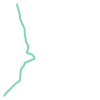

In [183]:
# 读取轨道线路gis文件
line = gpd.GeoDataFrame.from_file('data/line.json', encoding='utf-8')
# 取出第一条线路
r = line.iloc[0]
# 提取其几何线型
line_geometry = r['geometry']
print(type(line_geometry))
# 查看数据
line_geometry

#### 4.1.4 生成轨道断面信息表

在利用站点对线路进行切分之前，需要先生成一个轨道断面信息表用于存储每个断面的起点站点、终点站点、所在的线路，之后在该表上添加每个断面线型的地理信息。首先提取上面的轨道线所对应的站点，并用shift整体上移一行的形式构建轨道断面信息表。

In [184]:
# 提取相应的站点
tmp = stop[stop['linename'] == r['linename']]
# 生成轨道断面信息表
for i in tmp.columns:
    tmp[i + '1'] = tmp[i].shift(-1)
tmp = tmp.iloc[:-1]
tmp = tmp[['stationnames', 'stationnames1',
           'geometry', 'geometry1', 'linename']]
# 查询结果如下所示，表中的geometry与geometry1两列分别存储了该轨道断面所在的地理站点信息
tmp

,stationnames,stationnames1,geometry,geometry1,linename
28,莘庄,外环路,POINT (121.38112 31.11298),POINT (121.38839 31.12282),地铁1号线(莘庄-富锦路)
29,外环路,莲花路,POINT (121.38839 31.12282),POINT (121.39815 31.13275),地铁1号线(莘庄-富锦路)
30,莲花路,锦江乐园,POINT (121.39815 31.13275),POINT (121.40953 31.14387),地铁1号线(莘庄-富锦路)
31,锦江乐园,上海南站,POINT (121.40953 31.14387),POINT (121.42522 31.15678),地铁1号线(莘庄-富锦路)
32,上海南站,漕宝路,POINT (121.42522 31.15678),POINT (121.43029 31.17029),地铁1号线(莘庄-富锦路)
33,漕宝路,上海体育馆,POINT (121.43029 31.17029),POINT (121.43182 31.18388),地铁1号线(莘庄-富锦路)
34,上海体育馆,徐家汇,POINT (121.43182 31.18388),POINT (121.43373 31.19467),地铁1号线(莘庄-富锦路)
35,徐家汇,衡山路,POINT (121.43373 31.19467),POINT (121.44215 31.20688),地铁1号线(莘庄-富锦路)
36,衡山路,常熟路,POINT (121.44215 31.20688),POINT (121.44671 31.21552),地铁1号线(莘庄-富锦路)
37,常熟路,陕西南路,POINT (121.44671 31.21552),POINT (121.45564 31.21923),地铁1号线(莘庄-富锦路)


####  4.1.5 轨道断面线型的生成

在这一小节中，我们需要对轨道断面信息表中的每一行生成相应的轨道断面线型，而这里要用的方法是Shapely中线要素LineString自带的投影project和差值interpolate方法：

- 投影：给定线和点，投影方法能够在线上找出与点最近的位置，并返回从线起点开始到该位置经过的距离。
- 插值：给定线和距离，插值方法能够在线上找出从线起点开始经过这一距离的所在位置点，所产生的点在线上。

投影与插值代表的是两个相反的过程，投影将地理信息要素转换为距离，而插值将距离转换为地理信息要素。如果将这两个功能结合使用，就可以为空间上任意一点找到线上最近位置。搭配使用这两个方法，就可以实现轨道断面线型的提取。具体思路如下：

1. 对每一个轨道断面线型，通过投影提取其起点与终点在轨道线型上所在的位置，这两者的位置以距离表示，分别记为o_project和d_project。
2. 在距离o_project和d_project之间以相等间隔插入n个值，作为轨道断面线型的坐标点位置。
3. 用插值将这些坐标点位置由距离转换为地理信息要素，并构成线型。

接下来用代码实现，首先是起终点位置的投影：


In [185]:
# 提取轨道段起终点在线路上对应的位置
tmp['o_project'] = tmp['geometry'].apply(lambda r1: r['geometry'].project(r1))
tmp['d_project'] = tmp['geometry1'].apply(lambda r1: r['geometry'].project(r1))
# 输出结果如下图所示，由于站点与线路均为地理坐标系，起终点的投影距离为直接用经纬度计算的距离，如果需要获得实际距离，则可以对站点与线路投影后进行计算。
tmp

,stationnames,stationnames1,geometry,geometry1,linename,o_project,d_project
28,莘庄,外环路,POINT (121.38112 31.11298),POINT (121.38839 31.12282),地铁1号线(莘庄-富锦路),0.000598,0.012812
29,外环路,莲花路,POINT (121.38839 31.12282),POINT (121.39815 31.13275),地铁1号线(莘庄-富锦路),0.012812,0.026746
30,莲花路,锦江乐园,POINT (121.39815 31.13275),POINT (121.40953 31.14387),地铁1号线(莘庄-富锦路),0.026746,0.042661
31,锦江乐园,上海南站,POINT (121.40953 31.14387),POINT (121.42522 31.15678),地铁1号线(莘庄-富锦路),0.042661,0.063146
32,上海南站,漕宝路,POINT (121.42522 31.15678),POINT (121.43029 31.17029),地铁1号线(莘庄-富锦路),0.063146,0.078490
33,漕宝路,上海体育馆,POINT (121.43029 31.17029),POINT (121.43182 31.18388),地铁1号线(莘庄-富锦路),0.078490,0.092131
34,上海体育馆,徐家汇,POINT (121.43182 31.18388),POINT (121.43373 31.19467),地铁1号线(莘庄-富锦路),0.092131,0.103139
35,徐家汇,衡山路,POINT (121.43373 31.19467),POINT (121.44215 31.20688),地铁1号线(莘庄-富锦路),0.103139,0.118129
36,衡山路,常熟路,POINT (121.44215 31.20688),POINT (121.44671 31.21552),地铁1号线(莘庄-富锦路),0.118129,0.128608
37,常熟路,陕西南路,POINT (121.44671 31.21552),POINT (121.45564 31.21923),地铁1号线(莘庄-富锦路),0.128608,0.138280


接下来将距离插值和线型生成融合到一个函数中，该函数的输入是轨道断面信息表的行和轨道线型，输出则是对应的轨道断面线型。

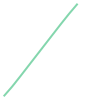

In [186]:
# 定义函数：输入每一行轨道段和轨道线，输出是轨道断面信息的LineString
def getline(r2, line_geometry):
    # 生成空的list用以存放轨道断面的节点
    ls = []
    # 对大部分情况，线段的起点的位置在终点前，在起终点之间生成10个点
    if r2['o_project'] < r2['d_project']:
        # numpy的linespace线性插值生成10个点距离线段起点的距离
        tmp1 = np.linspace(r2['o_project'], r2['d_project'], 10)
    # 对四号线环线，最后一个站点与第一个站点之间的轨道断面需要特殊处理
    if r2['o_project'] > r2['d_project']:
        tmp1 = np.linspace(
            r2['o_project'] - line_geometry.length, r2['d_project'], 10)
        tmp1[tmp1 < 0] = tmp1[tmp1 < 0] + line_geometry.length
    # tmp1存储的是点距离线段起点的距离，将每个距离转换为点要素，并添加到ls中
    for j in tmp1:
        ls.append(line_geometry.interpolate(j))
    # 最后，把点序列转换为线型输出
    return LineString(ls)


# 取出轨道断面信息表的其中一行，将其输入函数，测试函数能否顺利运行。
getline(tmp.iloc[0], line_geometry)

将前面定义的函数使用apply方法逐行遍历，对轨道断面信息表中的每一个断面生成相应的地理信息赋值给geometry列，然后将其转化为GeoDataFrame。

<Axes: >

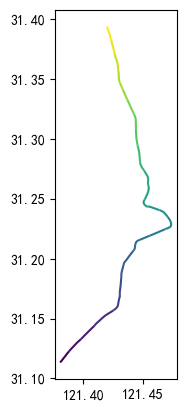

In [187]:
# 遍历提取轨道段
tmp['geometry'] = tmp.apply(lambda r2: getline(r2, line_geometry), axis=1)
tmp = gpd.GeoDataFrame(tmp)
# 输出结果如下图所示，为了区分不同的轨道断面，绘制时以o_project列的值的大小作为颜色映射，使每一个断面拥有不同的颜色。
# 最终轨道线型出现了渐变，证明它已经被成功地切分为多个断面。
tmp.plot(column='o_project')

#### 4.1.6 循环遍历提取全部轨道断面信息

成功对一条轨道线路切分断面后，接下来只需要以循环的方式对每一条轨道线路都提取其线型与站点信息，生成轨道断面信息，并在最后汇总成一个大表即可。

<Axes: >

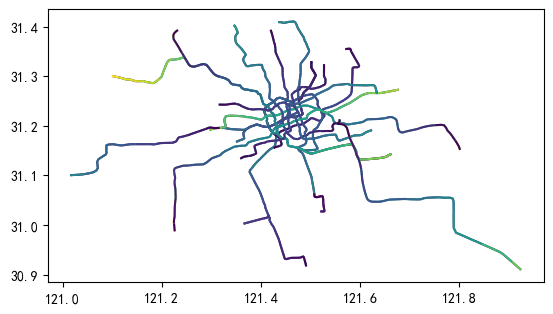

In [188]:
# 用轨道站点对轨道线进行切分
lss = []
# 遍历每条轨道线
for k in range(len(line)):
    r = line.iloc[k]
    # 获取轨道线的线型
    line_geometry = r['geometry']
    # 提取相应的站点
    tmp = stop[stop['linename'] == r['linename']]
    # 生成轨道段
    for i in tmp.columns:
        tmp[i + '1'] = tmp[i].shift(-1)
    tmp = tmp.iloc[:-1]
    tmp = tmp[['stationnames', 'stationnames1',
               'geometry', 'geometry1', 'linename']]
    # 提取轨道段起终点在线路上对应的位置
    tmp['o_project'] = tmp['geometry'].apply(
        lambda r1: r['geometry'].project(r1))
    tmp['d_project'] = tmp['geometry1'].apply(
        lambda r1: r['geometry'].project(r1))
    # 遍历提取轨道段
    tmp['geometry'] = tmp.apply(lambda r2: getline(r2, line_geometry), axis=1)
    # 提取的轨道段放进list中
    lss.append(tmp)
# 遍历完后，合并list里的表，得到轨道断面信息表
metro_line_splited = pd.concat(lss)
# 绘制轨道断面
metro_line_splited.plot(column='o_project')

观察四号线环线正确性

<Axes: >

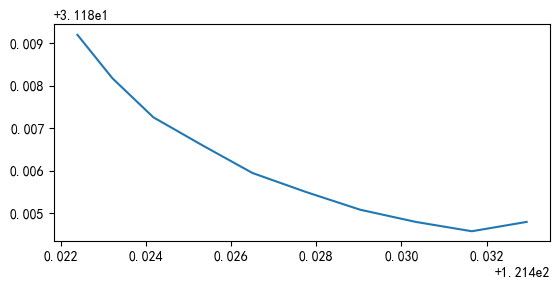

In [189]:
# 观察四号线环线的最后一段有没有补上
metro_line_splited[metro_line_splited['linename']
                   == '地铁4号线(内圈(宜山路-宜山路))'].iloc[-1:].plot()

对提取出来的轨道断面线型做整理，并将其存储为本地文件以备后续使用。

In [190]:
# 提取线路名
metro_line_splited['line'] = metro_line_splited['linename'].apply(
    lambda r: r.split('(')[0].lstrip('地铁'))
# 五号线支线 去掉 支线两个字
metro_line_splited.loc[metro_line_splited['line'] == '5号线支线', 'line'] = '5号线'
# 补齐起终点站点名称
metro_line_splited['o'] = metro_line_splited['line'] + \
                          metro_line_splited['stationnames']
metro_line_splited['d'] = metro_line_splited['line'] + \
                          metro_line_splited['stationnames1']
# 提取有用的列
metro_line_splited = metro_line_splited[['o', 'd', 'geometry']]
# 存储分割的轨道断面线型,如果数据中有中文，编码格式注意要encoding = 'utf-8'，否则再读取会显示乱码。同时，存储时也需要保证只有geometry一列内容为地理图形要素，如果存在其他列，则存储也会失败
metro_line_splited.to_file(
    r'data/metro_line_splited.json', driver='GeoJSON', encoding='utf-8')

通过上面的整理，与前面推算的轨道断面客流可以直接用o与d两列进行对应。通过pd.merge表连接即可将客流连接至对应的断面。

In [191]:
metro_line_toplot = pd.merge(
    metro_line_splited, metro_passenger, on=['o', 'd'])

### 4.2 线型平移与蛛网图绘制

生成轨道线型并对应断面客流后，下一步是客流的可视化，其思路是在轨道线路的两边生成线，并以线段的粗细和颜色表示客流量。而这一步骤只需要将切分的轨道断面往两侧平移，并在绘图时指定线段的粗细和颜色即可。

注意，pycharm更新后的bug会导致生成的图片背景不为白色，有点奇怪，vscode是正常的，为了保证视觉效果，请不要使用pycharm。

#### 4.2.1 线型平移

需要注意的是，GIS文件中的线要素是存在方向的，线要素的坐标点排列顺序即代表了线的方向。在轨道线路数据中保留了轨道的双向信息，即一条轨道在GIS文件中会有两个线型，而这两个线型的GIS文件重合，但坐标点的排列顺序相反，线的方向相反。也因此，在对双向的轨道线切分成轨道断面地理信息要素后，每个断面会留有双向的线型，坐标点排列顺序相反。

将轨道断面平移时，由于同一断面存在两个反方向的线型，只需要对所有线型都统一往其方向的左侧或右侧平移，显示效果即为沿轨道方向两侧分布。由断面的客流量大小决定平移的距离，后续可视化中也以线段的粗细颜色代表客流量，当平移距离与线段粗细调整得刚刚好的时候，呈现出来的效果即为在轨道线处区分双向线段。线条越粗、颜色越深代表客流量越多。原理如下：

![image](images/轨道断面平移原理.jpg)

在对轨道断面平移时，使用的是Shapely中线要素的parallel_offset方法。通过给定距离与平移方向，该方法可以将线段平移相应距离，并自动在线段的关节处生成连接。

接下来，我们对轨道断面依据客流大小分成10组，每一组的线宽不同，并根据线宽设置平移的距离。

In [192]:
groupnum = 10
metro_line_toplot = metro_line_toplot.sort_values(by='count')
metro_line_toplot['linewidth'] = (np.arange(
    len(metro_line_toplot)) * groupnum / len(metro_line_toplot)).astype(int) / groupnum + 0.1
# 平移轨道线
metro_line_parallel = metro_line_toplot.copy()
# 设定平移的距离比例，这个参数与后面绘图的线宽对应，两者需要一起调整
rate = 0.004
# 对轨道断面线型平移
metro_line_parallel['geometry'] = metro_line_parallel.apply(
    lambda r: r['geometry'].parallel_offset(rate * r['linewidth']), axis=1)
# 扩样25倍
metro_line_parallel['count'] *= 25

删除空信息列

In [193]:
# 删除空的geometry
metro_line_parallel = metro_line_parallel[-metro_line_parallel.is_empty]
metro_line_parallel

,o,d,geometry,count,linewidth
785,13号线世博大道,13号线长清路,"LINESTRING (121.47953 31.18435, 121.47986 31.1...",25,0.1
784,13号线世博会博物馆,13号线世博大道,"LINESTRING (121.47712 31.19861, 121.47790 31.1...",25,0.1
783,13号线马当路,13号线世博会博物馆,"LINESTRING (121.47137 31.21191, 121.47185 31.2...",25,0.1
788,16号线滴水湖,16号线临港大道,"LINESTRING (121.92575 30.90974, 121.92368 30.9...",75,0.1
778,13号线汉中路,13号线自然博物馆,"LINESTRING (121.45376 31.24236, 121.45439 31.2...",75,0.1
...,...,...,...,...,...
275,2号线静安寺,2号线南京西路,"LINESTRING (121.44332 31.22144, 121.44488 31.2...",36000,1.0
3,1号线锦江乐园,1号线上海南站,"LINESTRING (121.41253 31.14146, 121.41375 31.1...",36525,1.0
6,1号线上海体育馆,1号线徐家汇,"LINESTRING (121.43582 31.18364, 121.43589 31.1...",36600,1.0
4,1号线上海南站,1号线漕宝路,"LINESTRING (121.42755 31.15353, 121.42894 31.1...",40125,1.0


#### 4.2.2 绘制蛛网图

最后我们对轨道断面客流进行可视化，其中线宽的大小与轨道断面平移的距离应该同时进行调整，确保它们能够相互对应，呈现出我们需要的可视化效果。

注意，如果是在pycharm中运行，且编辑器主题是黑色模式的情况下，图片的背景颜色会变成黑色，我到最后都没找到这种情况出现的原因，而vscode不管什么主题都是白色的背景颜色，因此建议不要使用pycharm运行，毕竟白色背景下生成的蛛网图比较好看。

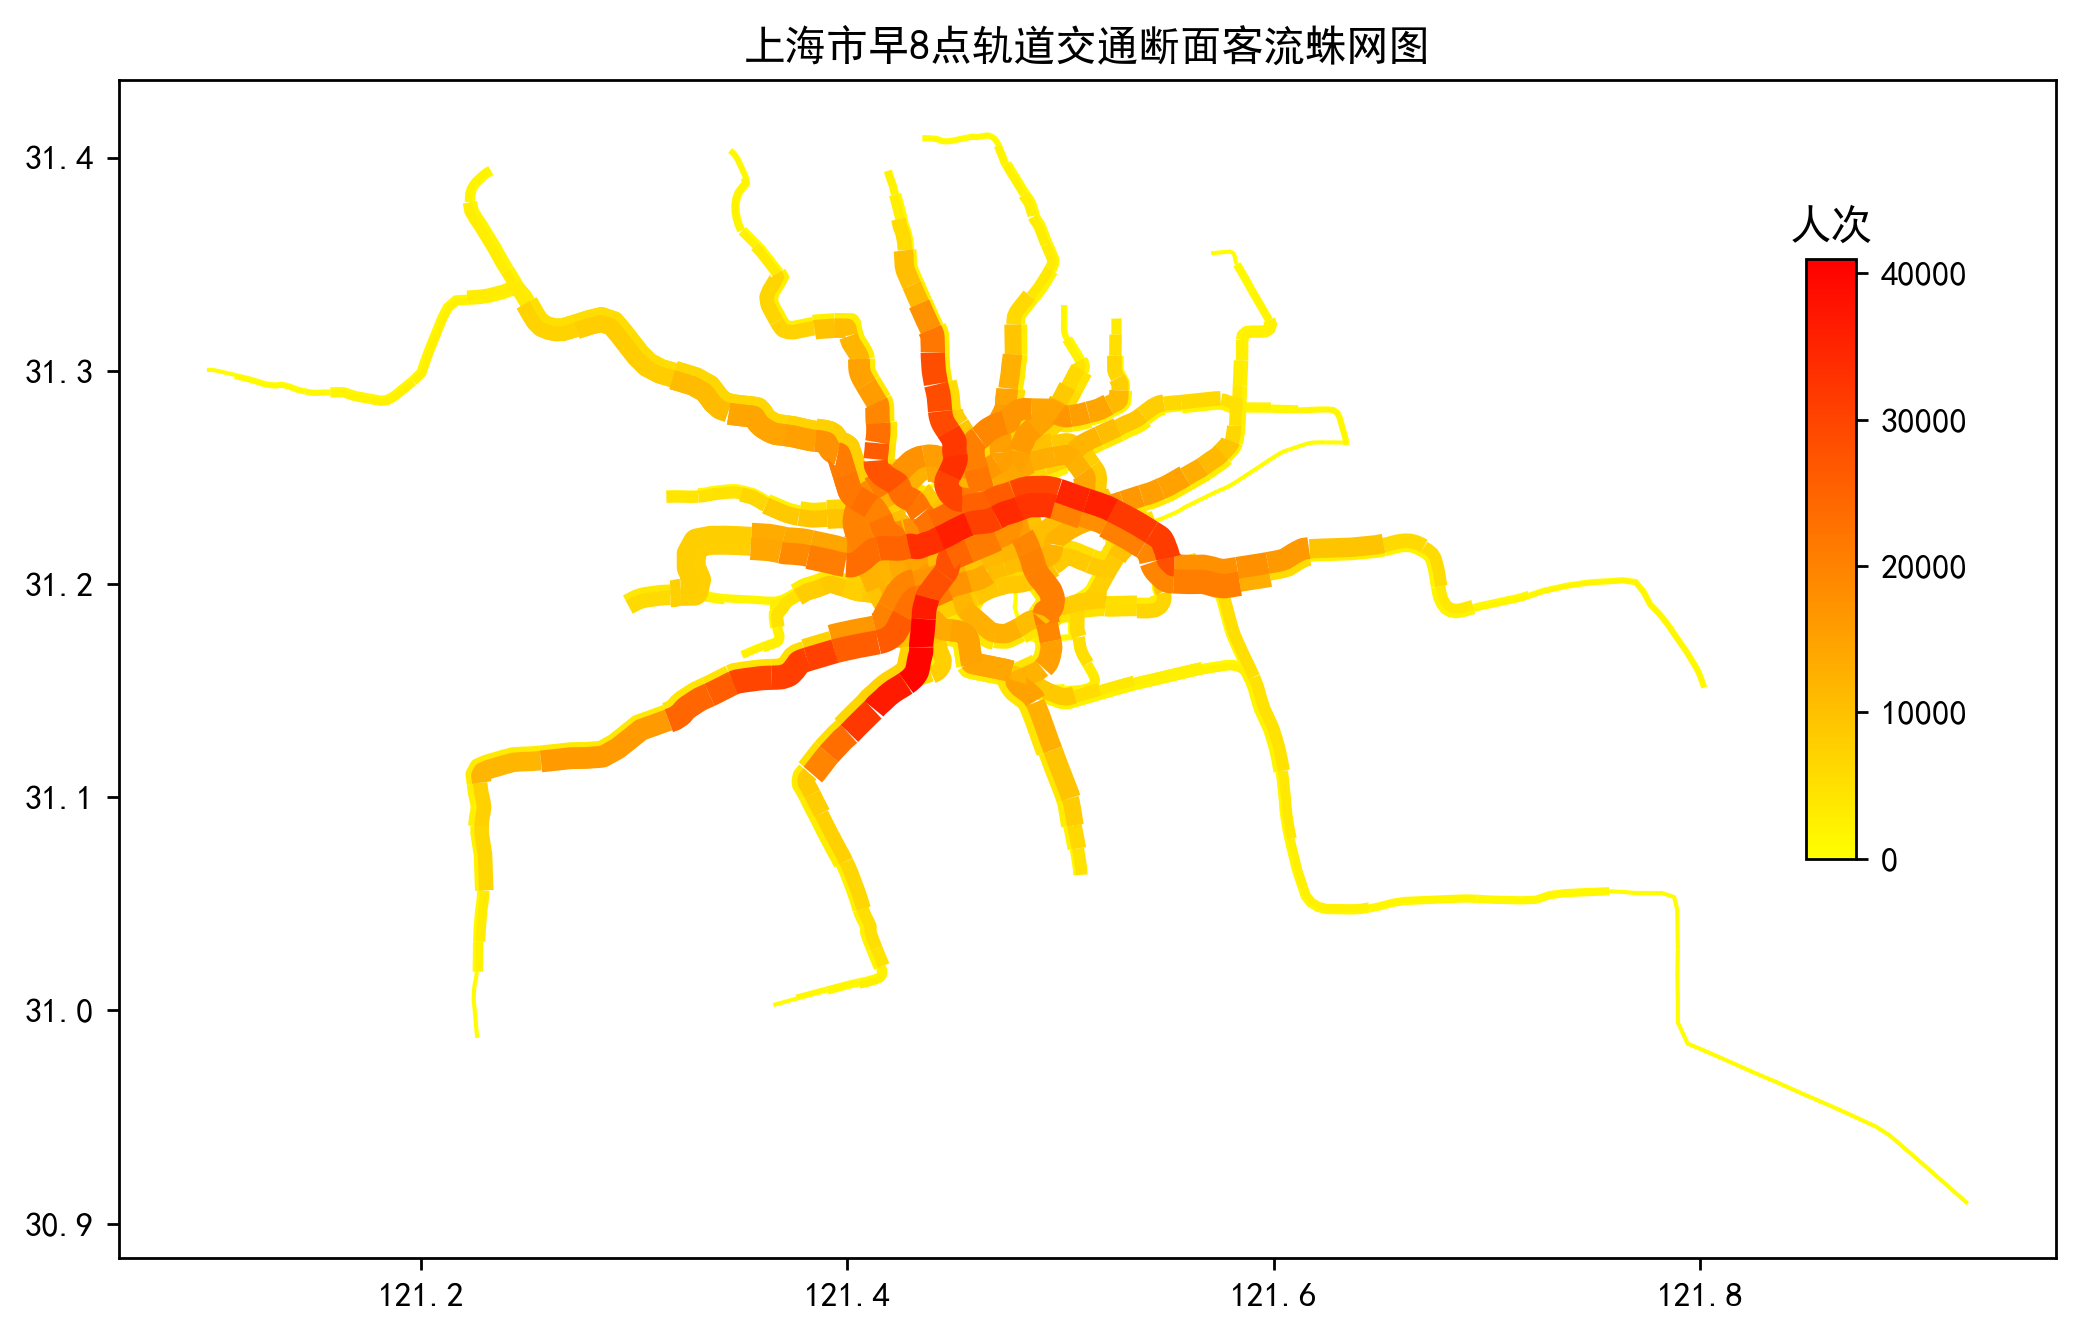

In [194]:
# 绘制轨道断面蛛网图
fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=250)
# 设置colorbar
cax = plt.axes([0.8, 0.4, 0.02, 0.3])
plt.title('人次')
plt.sca(ax)
# 绘制轨道客流，这里线宽参数与前面平移的距离比例对应，两者需要一起调整
metro_line_parallel.plot(ax=ax, column='count',
                         lw=metro_line_parallel['linewidth'] * 7,  # 设置线型的粗细
                         cmap=matplotlib.cm.get_cmap('autumn_r'), vmin=0, vmax=metro_line_parallel['count'].max(),
                         legend=True, cax=cax)
plt.title('上海市早8点轨道交通断面客流蛛网图')
plt.show()

从上图我们可以看出，在早8点，1号线、5号线、9号线在往市中心的方向上的客流是比较多的，当然大部分延伸到郊区的地铁线路的往市中心方向的客流量都会比往郊外方向的客流量多，这无不体现了上海市职住分离的一种趋势。而最引人注目的是2号线，其作为贯穿市中心东西方向的地铁线，其两个方向上的客流都较为频繁，是重要的交通线路，因此这个时间段我们可以在2号线上多增加运行车次来缓解客运压力。

下面是有上海市行政区划边界的GeoJSON做底图的蛛网图。

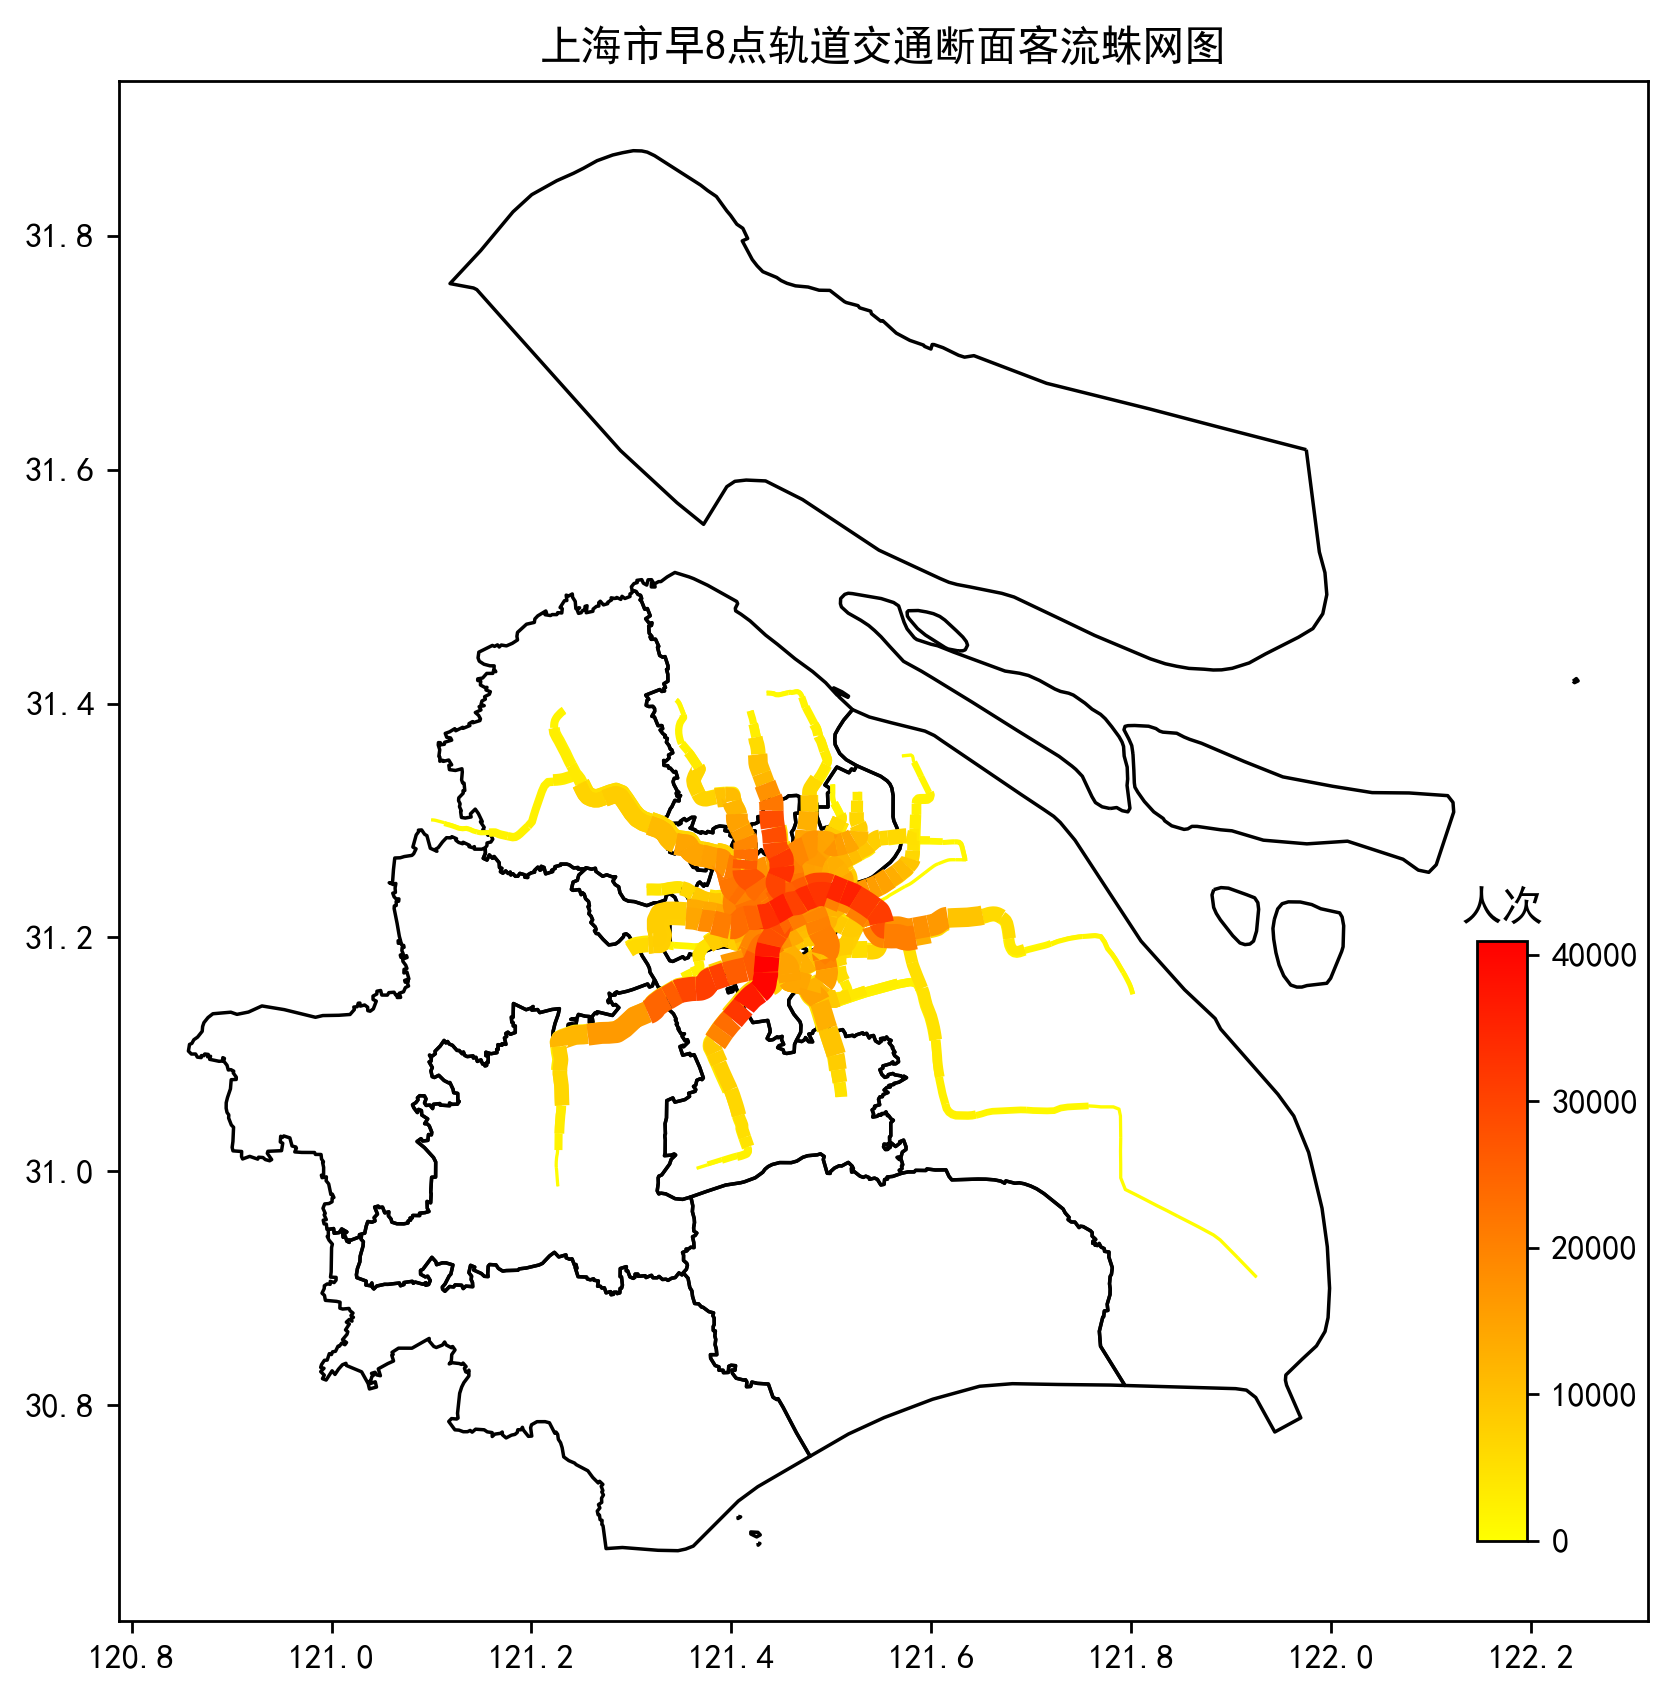

In [195]:
# 也可以使用下载好的矢量边界，下载的数据和下面在线获取的数据是一样的
# gpd.read_file('data/shanghai.json')
# 绘制轨道断面蛛网图
fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=250)
# 设置colormap的数据
# 设置colorbar
cax = plt.axes([0.75, 0.15, 0.02, 0.3])
plt.title('人次')
plt.sca(ax)
# 绘制轨道客流，这里线宽参数与前面平移的距离比例对应，两者需要一起调整
metro_line_parallel.plot(ax=ax, column='count',
                         lw=metro_line_parallel['linewidth'] * 7,  # 设置线型的粗细
                         cmap=matplotlib.cm.get_cmap('autumn_r'), vmin=0, vmax=metro_line_parallel['count'].max(),
                         legend=True, cax=cax)
plt.title('上海市早8点轨道交通断面客流蛛网图')
# 绘制上海市地理边界
# 数据来源于阿里云数据可视化平台
# http://datav.aliyun.com/portal/school/atlas/area_selector
gpd.read_file('https://geo.datav.aliyun.com/areas_v3/bound/310000_full.json').plot(ax=ax, facecolor='none',
                                                                                   edgecolor='black')
plt.show()

## 结语

到这里我的项目就结束了。回过头来看，这份大作业的难点和亮点在于怎么将实际的地铁线网转化为图数据结构、怎么将OD数据与地铁线网建立空间关联、使用蛛网图进行可视化的思路等。

如果我进一步的对每一个时段的客流量进行分析的话，可以得出关于客流量的结论，例如流量在高峰时段和繁忙的地铁线路上明显增加，而在非高峰时段和相对较冷门的线路上相对较少，这些结论对于上海市轨道交通的运营和规划具有重要意义，可以帮助决策者更好地调整车次和优化线路。我还可以探究客流分布的空间特征，例如一些特定的地铁站点在不同时间段内吸引了更多的乘客，可能是因为其周围有商业区、居民区或者重要的交通枢纽，这些特征的分析可以为城市规划和商业发展提供有价值的参考。

但由于工作量的缘故，我只针对早8点的2号线做了断面客流柱状图，以及对早8点的所有线路做了断面客流蛛网图，但这些内容做下来已然让我受益匪浅。我收获了一套处理、分析od数据的思路和可视化的方法，例如如果下次我拥有的是公交车的刷卡数据，那我就可以将其与公路网数据结合来进行类似的分析等。

然而，本项目也存在一些不足之处。首先，由于数据限制，我们无法获取到每位乘客的具体出行目的和行为，无法进行更深入的分析。此外，数据的时效性也可能对分析结果产生影响，从2015年到2023年，乘客的出行模式和行为随着时间的推移发生变化的概率极高。因此，希望在未来的类似项目中能够获得更详细和实时的数据，以提高分析的准确性和可靠性。

总的来说，通过对上海市轨道交通地铁IC刷卡数据的客流分析，我能够得出一些重要的结论，并为城市规划和交通管理提供了有价值的信息。然而，我也认识到项目中的不足之处，并提出了改进的建议，希望在未来的研究中能够取得更好的结果。